In [13]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [14]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal
from langchain_sambanova import ChatSambaNova

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
#summarization_model = init_chat_model(model="openai:gpt-4o-mini")
summarization_model = ChatSambaNova(model="Llama-4-Maverick-17B-128E-Instruct", temperature=0.0)
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [15]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos
from langchain_sambanova import ChatSambaNova

# Create agent using create_react_agent directly
model = ChatSambaNova(model="Llama-4-Maverick-17B-128E-Instruct", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [16]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [17]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

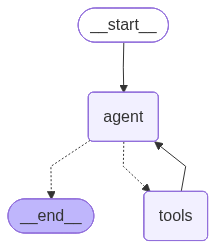

In [8]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [18]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": {                                                                                                    │
│     "type": "array",                                                                                            │
│     "items": {                                                                                                  │
│       "type": "object",                                                                                         │
│       "properties": {                                                                                           │
│         "content": {                                                                                            │
│           "type": "string"                                                                                      │
│         },                                                                                                      │
│         "status": {                                                                                             │
│           "type": "string",                                                                                     │
│           "enum": [                                                                                             │
│             "pending",                                                                                          │
│             "in_progress",                                                                                      │
│             "completed"                                                                                         │
│           ]                                                                                                     │
│         }                                                                                                       │
│       },                                                                                                        │
│       "required": [                                                                                             │
│         "content",                                                                                              │
│         "status"                                                                                                │
│       ]                                                                                                         │
│     },                                                                                                          │
│     "value": [                                                                                                  │
│       {                                                                                                         │
│         "content": "Research Model Context Protocol (MCP)",                                                     │
│         "status": "in_progress"                                                                                 │
│       }                                                                                                         │
│     ]                                                                                                           │
│   }                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for write_todos                                                                       │
│ todos                                                                                                           │
│   Input should be a valid list }, input_type=dict]                                                              │
│     For further information visit https://errors.pydantic.dev/2.11/v/list_type                                  │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP)",                                                       │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_926375a350b542f794                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'in_progress'}]            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) overview",                                              │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_8cf9d5cd67384edc85                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard introduced by Anthropic that enables AI assistants to      │
│ connect to various data sources securely. It facilitates two-way interactions between AI-powered tools and      │
│ external data sources, allowing for enhanced AI capabilities and streamlined workflows.                         │
│                                                                                                                 │
│ Key features of MCP include:                                                                                    │
│ 1. Secure authentication and data retrieval                                                                     │
│ 2. Action execution capabilities                                                                                │
│ 3. Support for multiple data sources                                                                            │
│ 4. Pre-built servers for popular enterprise systems                                                             │
│                                                                                                                 │
│ MCP's architecture allows for the development of both servers and clients. Servers expose data and tools to AI  │
│ assistants, while clients connect to these servers to leverage the available resources.                         │
│                                                                                                                 │
│ The benefits of MCP include:                                                                                    │
│ 1. Enhanced AI capabilities through access to external data and tools                                           │
│ 2. Streamlined workflows by integrating AI assistants with existing systems                                     │
│ 3. Flexibility in supporting various data sources and enterprise systems                                        │
│                                                                                                                 │
│ Overall, MCP provides a robust framework for integrating AI assistants with external data sources and tools,    │
│ enhancing their functionality and utility in various applications.                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP)",                                                       │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_49e31d089655432fb0                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'completed'}]              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard that enables AI assistants to securely connect to various  │
│ data sources. It facilitates two-way interactions between AI tools and external data, enhancing AI capabilities │
│ and streamlining workflows. Key features include secure authentication, data retrieval, and action execution.   │
│ MCP supports multiple data sources and has pre-built servers for popular enterprise systems. Its architecture   │
│ allows for both server and client development, enhancing AI functionality and utility in various applications.  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

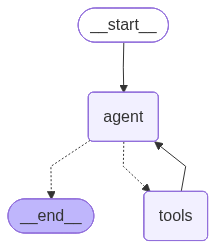

In [19]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [20]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me a quick overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me a quick overview of Model Context Protocol (MCP).                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": {                                                                                                    │
│     "type": "array",                                                                                            │
│     "items": {                                                                                                  │
│       "type": "object",                                                                                         │
│       "properties": {                                                                                           │
│         "content": {                                                                                            │
│           "type": "string"                                                                                      │
│         },                                                                                                      │
│         "status": {                                                                                             │
│           "type": "string",                                                                                     │
│           "enum": [                                                                                             │
│             "pending",                                                                                          │
│             "in_progress",                                                                                      │
│             "completed"                                                                                         │
│           ]                                                                                                     │
│         }                                                                                                       │
│       },                                                                                                        │
│       "required": [                                                                                             │
│         "content",                                                                                              │
│         "status"                                                                                                │
│       ]                                                                                                         │
│     },                                                                                                          │
│     "value": [                                                                                                  │
│       {                                                                                                         │
│         "content": "Research Model Context Protocol (MCP)",                                                     │
│         "status": "pending"                                                                                     │
│       }                                                                                                         │
│     ]                                                                                                           │
│   }                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for write_todos                                                                       │
│ todos                                                                                                           │
│   Input should be a valid list }, input_type=dict]                                                              │
│     For further information visit https://errors.pydantic.dev/2.11/v/list_type                                  │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP)",                                                       │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_180c00984de8427892                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'pending'}]                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) overview",                                              │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_dff858aa39d34fa7bd                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) overview",                                              │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_6a812cbdbe9a474397                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) overview"                                                              │
│ }                                                                                                               │
│    ID: call_b9c52a65f88f483e87                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard introduced by Anthropic for connecting AI assistants to    │
│ data sources. It enables secure, two-way connections between data sources and AI tools, allowing for features   │
│ like secure authentication, data streaming, and flexible data handling.                                         │
│                                                                                                                 │
│ Key aspects of MCP include:                                                                                     │
│ 1. **Functionality**: MCP facilitates secure communication between AI assistants and various data sources. It   │
│ supports two-way communication, enabling both the AI and the data source to interact dynamically.               │
│ 2. **Benefits**: The protocol offers several benefits, including enhanced security through authentication       │
│ mechanisms, flexibility in handling different data formats and protocols, and extensibility to support various  │
│ applications.                                                                                                   │
│ 3. **Implementation**: MCP can be implemented through the development of servers that expose data and tools,    │
│ and clients that connect to these servers. The protocol provides guidelines and SDKs for building both MCP      │
│ servers and clients, making it easier for developers to integrate their applications.                           │
│                                                                                                                 │
│ MCP has been adopted by companies like Block and Apollo, indicating its potential for practical applications in │
│ various industries. The protocol's design allows it to be versatile and adaptable to different use cases,       │
│ making it a significant development in the field of AI and data integration.                                    │
│                                                                                                                 │
│ For those interested in implementing MCP, detailed documentation is available, including guides on getting      │
│ started, architecture, and development resources for building servers and clients. The MCP ecosystem also       │
│ includes tools like the MCP Inspector for debugging and monitoring MCP connections.                             │
│                                                                                                                 │
│ Overall, MCP represents a significant step forward in enabling more sophisticated and secure interactions       │
│ between AI systems and data sources, with potential applications across a wide range of industries and use      │
│ cases.                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard introduced by Anthropic that enables AI assistants to      │
│ connect to various data sources and tools securely. It facilitates two-way communication between AI-powered     │
│ applications and data sources, allowing for both the retrieval and update of information. MCP features secure   │
│ authentication and data access mechanisms, making it suitable for enterprise environments. Pre-built servers    │
│ are available for popular enterprise systems, simplifying integration.                                          │
│                                                                                                                 │
│ Key aspects of MCP include:                                                                                     │
│ 1. **Architecture**: MCP is designed to support a wide range of data sources and tools, providing a             │
│ standardized way for AI assistants to interact with them.                                                       │
│ 2. **Servers and Clients**: MCP servers expose data and tools to AI assistants, while MCP clients are           │
│ applications that connect to these servers. Developers can build both servers and clients using provided SDKs   │
│ and guidelines.                                                                                                 │
│ 3. **Security**: MCP emphasizes secure authentication and data access, ensuring that interactions between AI    │
│ assistants and data sources are protected.                                                                      │
│ 4. **Applications**: MCP can enable various applications, including enterprise AI solutions that require access │
│ to diverse data sources and tools.                                                                              │
│                                                                                                                 │
│ By providing a standardized protocol for connecting AI assistants to data sources, MCP aims to enhance the      │
│ functionality and versatility of AI applications in different contexts, particularly in enterprise settings.    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol (MCP) overview':                                               │
│                                                                                                                 │
│ - URL_error_TMiU-lYa.md: [Model Context Protocol home page![Image 1: light                                      │
│ logo](https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/light.svg?fit=max&auto=format&n=4ZXF1PrDkEaJvXpn&q=85&s=449 │
│ 8cb8a57d574005f3dca62bdd49c95)![Image 2: dark                                                                   │
│ logo](https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/dark.svg?fit=max&auto=format&n=4ZXF1PrDkEaJvXpn&q=85&s=c068 │
│ 7c003f8f2cbdb24772ab4c8a522c)](https://modelcontextprotocol.io/)                                                │
│ [Documentation](https://modelcontextprotocol.io/docs/getting-started/intro)[Specification](https://modelcontext │
│ protocol.io/specification/2025-06-18)[Community](https://modelcontextprotocol.io/community/communication)[About │
│  MCP](https://modelcontextprotocol.io/about) *   [What is                                                       │
│ MCP?](https://modelcontextprotocol.io/docs/getting-started/intro) *                                             │
│ [Architecture](https://modelcontextprotocol.io/docs/learn/architecture) *                                       │
│ [Servers](https://modelcontextprotocol.io/docs/learn/server-concepts) *                                         │
│ [Clients](https://modelcontextprotocol.io/docs/learn/client-concepts) *   [Connect to local MCP                 │
│ servers](https://modelcontextprotocol.io/docs/develop/connect-local-servers) *   [Connect to remote MCP         │
│ Servers](https://modelcontextprotocol.io/docs/develop/connect-remote-servers) *   [Build an MCP                 │
│ server](https://modelcontextprotocol.io/docs/develop/build-server) *   [Build an MCP                            │
│ client](https://modelcontextprotocol.io/docs/develop/build-client) *                                            │
│ [SDKs](https://modelcontextprotocol.io/docs/sdk) *   [MCP                                                       │
│ Inspector](https://modelcontextprotocol.io/docs/tools/inspector) *   [What can MCP                              │
│ enable?](https://modelcontextprotocol.io/#what-can-mcp-enable%3F) *   [Why does MCP                             │
│ matter?](https://modelcontextprotocol.io/#why-does-mcp-matter%3F) *   [Start                                    │
│ Building](https://modelcontextprotocol.io/#start-building) *   [Learn                                           │
│ more](https://modelcontextprotocol.io/#learn-more) [​](https://modelcontextprotocol.io/#what-can-mcp-enable%3F)  │
│ [​](https://modelcontextprotocol.io/#why-does-mcp-matter%3F) [​](https://modelcontextprotocol.io/#start-building) │
│ [Build servers ------------- Create MCP servers to expose your data and                                         │
│ tools](https://modelcontextprotocol.io/docs/develop/build-server)[Build clients ------------- Develop           │
│ applications that connect to MCP servers](https://modelcontextprotocol.io/docs/develop/build-client)            │
│ [​](https://modelcontextprotocol.io/#learn-more) [Understand concepts ------------------- Learn the core         │
│ concepts and architecture of MCP](https://modelcontextprotocol.io/docs/learn/architecture)                      │
│ [Architecture](https://modelcontextprotocol.io/docs/learn/architecture)...                                      │
│                                                                                                                 │
│ Files: URL_error_TMiU-lYa.md                                                                                    │
│ 💡 Use read_file() to access full details when needed

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/mnt/data/URL_error_TMiU-lYa.md",                                                               │
│   "limit": null,                                                                                                │
│   "offset": null                                                                                                │
│ }                                                                                                               │
│    ID: call_b438de9b443f4c788f                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 2 validation errors for read_file                                                                        │
│ offset                                                                                                          │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│ limit                                                                                                           │
│   Input should be a valid integer                                                                               │
│     For further information visit https://errors.pydantic.dev/2.11/v/int_type                                   │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/mnt/data/URL_error_TMiU-lYa.md",                                                               │
│   "limit": 2000,                                                                                                │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: call_48c9e25712bc41a8b2                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP)",                                                       │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_4301d08dc75d4624b5                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: File '/mnt/data/URL_error_TMiU-lYa.md' not found                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'completed'}]              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard that enables AI assistants to connect securely to various  │
│ data sources and tools. It facilitates two-way communication between AI-powered applications and data sources,  │
│ allowing for both the retrieval and update of information. MCP features secure authentication and data access   │
│ mechanisms, making it suitable for enterprise environments.                                                     │
│                                                                                                                 │
│ Key aspects of MCP include:                                                                                     │
│ 1. **Architecture**: MCP is designed to support a wide range of data sources and tools, providing a             │
│ standardized way for AI assistants to interact with them.                                                       │
│ 2. **Servers and Clients**: MCP servers expose data and tools to AI assistants, while MCP clients are           │
│ applications that connect to these servers. Developers can build both servers and clients using provided SDKs   │
│ and guidelines.                                                                                                 │
│ 3. **Security**: MCP emphasizes secure authentication and data access, ensuring that interactions between AI    │
│ assistants and data sources are protected.                                                                      │
│ 4. **Applications**: MCP can enable various applications, including enterprise AI solutions that require access │
│ to diverse data sources and tools.                                                                              │
│                                                                                                                 │
│ By providing a standardized protocol for connecting AI assistants to data sources, MCP aims to enhance the      │
│ functionality and versatility of AI applications in different contexts, particularly in enterprise settings.    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->